In [37]:
# !pip install --upgrade pip
# !pip install numpy requests nlpaug
# !pip install comet_ml
# !pip install -q pyyaml h5py
# !pip install scikit-plot
# !pip install tensorflow
# !pip install websocket-client==0.47.0
# !pip3 install patool
# !pip3 install transformers
# !pip3 install dask
# !pip3 install 'fsspec>=0.3.3'
# !pip3 install torch torchvision

In [2]:
# import patoolib
# patoolib.extract_archive("/content/Archive.zip", outdir="/content/")

In [1]:

# Install libraries
from comet_ml import Experiment
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as nlpaw
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import seaborn as sns
import scikitplot as skplt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel, DistilBertConfig
import gc
import dask
import dask.dataframe as dd

# Import utility functions
# from train_utils import batch_encode

# Import matplotlib
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# Import utility functions
from data_utils import analyze_dist,augment_sentence,augment_text,combine_toxic_classes,get_relevant_words,undersample_majority

# Load the data
dask_df_train_valid = pd.read_csv('train.csv',engine='python', encoding='utf-8', error_bad_lines=False,header=None)
dask_df_train_valid.columns =['Result', 'Comment']
# dask_df_train_valid.npartitions

# dask_df_train_valid[0] = dask_df_train_valid[0].mask(dask_df_train_valid[0] == 1, 0)
# dask_df_train_valid[0] = dask_df_train_valid[0].mask(dask_df_train_valid[0] == 2, 1)

dask_df_train_valid.loc[dask_df_train_valid['Result'] == 1,'Result'] = 0
dask_df_train_valid.loc[dask_df_train_valid['Result'] == 2,'Result'] = 1


test = pd.read_csv('test.csv',engine='python', encoding='utf-8', error_bad_lines=False,header=None)
test.columns =['Result', 'Comment']
test.loc[test['Result'] == 1,'Result'] = 0
test.loc[test['Result'] == 2,'Result'] = 1


y_test=test['Result']
# Check data
# 1= Negative , 2 = Positive  

df_pos = dask_df_train_valid[dask_df_train_valid['Result'] == 1]
print("Total positives : ",df_pos.shape[0])

df_neg = dask_df_train_valid[dask_df_train_valid['Result'] == 0]
print("Total Negatives : ",df_neg.shape[0])


# Allow us to see full text (not truncated)
pd.set_option('display.max_colwidth', None)
dask_df_train_valid.head()

Total positives :  280000
Total Negatives :  280000


,Result,Comment
0,0,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
1,1,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life."
2,0,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money."
3,0,"I'm writing this review to give you a heads up before you see this Doctor. The office staff and administration are very unprofessional. I left a message with multiple people regarding my bill, and no one ever called me back. I had to hound them to get an answer about my bill. \n\nSecond, and most important, make sure your insurance is going to cover Dr. Goldberg's visits and blood work. He recommended to me that I get a physical, and he knew I was a student because I told him. I got the physical done. Later, I found out my health insurance doesn't pay for preventative visits. I received an $800.00 bill for the blood work. I can't pay for my bill because I'm a student and don't have any cash flow at this current time. I can't believe the Doctor wouldn't give me a heads up to make sure my insurance would cover work that wasn't necessary and was strictly preventative. The office can't do anything to help me cover the bill. In addition, the office staff said the onus is on me to make sure my insurance covers visits. Frustrating situation!"
4,1,"All the food is great here. But the best thing they have is their wings. Their wings are simply fantastic!! The \""Wet Cajun\"" are by the best & most popular. I also like the seasoned salt wings. Wing Night is Monday & Wednesday night, $0.75 whole wings!\n\nThe dining area is nice. Very family friendly! The bar is very nice is well. This place is truly a Yinzer's dream!! \""Pittsburgh Dad\"" would love this place n'at!!"


In [2]:

df_pos = dask_df_train_valid[dask_df_train_valid['Result'] == 1]
print("Total positives : ",df_pos.shape[0])

df_neg = dask_df_train_valid[dask_df_train_valid['Result'] == 0]
print("Total Negatives : ",df_neg.shape[0])

Total positives :  280000
Total Negatives :  280000


# We have Balanced dataset
In an unbalance dataset we end up with the model biased towards the majority class. Cause model hasn't seen/learned through enough examples about the minority class. In order to to handle unbalanced dataset we perform operations like Downsampling, Upsampling, SMOTEK etc. to balance the dataset. 

###### Now we gonna down sample our training dataset as data is huge for our computing resource.


In [4]:
#Test with multiple values 
downsamplePercentage=(0.8/100) #0.8 % Data of Original set

df_pos = df_pos.sample(n=(int)((df_pos.shape[0])*downsamplePercentage)) #Downsampling positive reviews

df_neg = df_neg.sample(n=(int)((df_neg.shape[0])*downsamplePercentage)) #Downsampling negative reviews

# join downsampled data and shuffle them
df = pd.concat([df_pos,df_neg]).sample(frac=1)
print(df.shape)

(4480, 2)


In [3]:
df.head()

,Result,Comment
293345,1,"Service was ok, food was mediocre. Their margaritas were awesome!"
479856,1,"Over-the-top cheesy entertainment, drunken tourists acting foolish, 80's rock music, and accompanying videos? All served alongside a comprehensive bourbon list including several cocktails and an ironic list of available Bartles and Jaymes wine coolers? Yes please!\n\nTake this place for what it is--a spoof of an 80's music bar in homage to Rock of Ages, the show playing at the Venetian--and don't get too serious about it. You'll probably have a good time."
340340,1,"This is a very mom and pop shop! If you're judgement is this based on the bathroom ambiance and service of a restaurant you're missing out. This place is an absolute favorite for my husband and I. Their shrimp fried rice is the best I've ever had! Their pho tai is amazing as well. Something that I would critique is that it seems like they add the beef before it's served vs. while it's being poured. Its not a flavor factor, more like a texture thing. I haven't tried their fried egg rolls only because their spring rolls have me hooked! Typically we order 2 soups, spring rolls and fried rice and pay a teeny bit over $20 (what a STEAL). The service is super fast but I think that there is a serious language barrier between servers and guests therefore it doesn't come off as friendly. Either way, this place is awesome and everyone that we have taken there had been impressed!"
55248,0,Sam woo in Los Angeles is better. I came in here last week and a roach crawled on my head as soon as we got seated no joke guys FYI
197748,0,"When Fry's first opened, I was impressed. But that was so short lived. I noticed they have a Ginormous store, and a lot to look at but everytime you want to make a purchase, they are out of everything and nobody in the store can tell you when it's coming in. That has happened to me several times with different items I've wanted and finally I decided that these people totally annoy me. I've waited 2 months for an item to come in and every week they tell me to call them and see if the truck has that merchandise. And every week they gave me the same story. Nope the truck didn't have that merchandise. Ok so you're an electronics store, and you have access to computers, and you have no clue as to what merchandise is coming or you can't give your customers any idea as to which year you will be receiving the merchandise that you are supposedly selling in your store. Their customer service is terrible. The only effort the employees will make is to breath, and that's about it. Well, there's other electronics stores who come through for me. If you don't need my money, I don't need your headache. No more Fry's for me."


In [4]:
# Generate 80-20 train-validation splits
X_train, X_valid, y_train, y_valid = train_test_split(df["Comment"],
                                                      df["Result"],
                                                      train_size=0.8,
                                                      stratify=df['Result'],
                                                      shuffle=True,
                                                      random_state=42)


In [5]:
# print(X_train)
# print(X_valid)
# print(y_train)
# print(y_valid)
np.unique(test["Result"])

array([0, 1])

In [8]:

def batch_encode(tokenizer=[], texts=pd.Series([]), batch_size=256, max_length=512):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,add_special_tokens = True,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
#         print("Tokenizing")
#         print(inputs)
#         print("\n")
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)



# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_valid.tolist())



# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, test['Comment'].tolist())

########## Ensure reproducibility ##########
# Set parameters:
params = {'MAX_LENGTH': 128,
          'EPOCHS': 8,
          'LEARNING_RATE': 0.01, # 3e-5
          'FT_EPOCHS': 6,
          'OPTIMIZER': 'adam',
          'FT_LEARNING_RATE': 0.005,
          'BATCH_SIZE': 64,
          'NUM_STEPS':  16,
          'DISTILBERT_DROPOUT': 0.2,
          'DISTILBERT_ATT_DROPOUT': 0.2,
          'LAYER_DROPOUT': 0.2,
          'KERNEL_INITIALIZER': 'GlorotNormal',
          'BIAS_INITIALIZER': 'zeros',
          'POS_PROBA_THRESHOLD': 0.5,          
          'ADDED_LAYERS': 'Dense 256, Dense 32, Dropout 0.2',
          'LR_SCHEDULE': '5e-5 for 6 epochs, Fine-tune w/ adam for 6 epochs @2e-5',
          'FREEZING': 'All DistilBERT layers frozen for 6 epochs, then unfrozen for 6',
          'CALLBACKS': '[early_stopping monitoring val_loss w/ patience=0]',
          'RANDOM_STATE':42
          }


# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(params['RANDOM_STATE'])

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(params['RANDOM_STATE'])

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(params['RANDOM_STATE'])

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed=params['RANDOM_STATE'])

## Build Model 
def build_model(transformer, max_length=512):
    """""""""
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.

    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
"""""""""
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=params['RANDOM_STATE']) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    
    D1 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(cls_token)
    
    X = tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)
    
    D2 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(X)
    
    X = tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)
    
    D3 = tf.keras.layers.Dropout(params['LAYER_DROPOUT'],
                                 seed=params['RANDOM_STATE']
                                )(X)
    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D3)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(lr=params['LEARNING_RATE']), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

<ipython-input-8-f0463a980e3e>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def batch_encode(tokenizer=[], texts=pd.Series([]), batch_size=256, max_length=512):


In [7]:
gc.collect()

20

In [8]:
params['NUM_STEPS']

16

In [9]:
params['LEARNING_RATE']

0.01

In [9]:
config = DistilBertConfig(dropout=params['DISTILBERT_DROPOUT'], 
                          attention_dropout=params['DISTILBERT_ATT_DROPOUT'], 
                          output_hidden_states=True)
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Freeze DistilBERT layers to preserve pre-trained weights 
for layer in distilBERT.layers:
    layer.trainable = False

# Build model
model = build_model(distilBERT)

# Train Weights of Added Layers and Classification Head 

# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = params['EPOCHS'],
    batch_size = params['BATCH_SIZE'],
    steps_per_epoch = params['NUM_STEPS'],
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=1
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/8
16/16 [==============================] - 727s 47s/step - loss: 0.8503 - accuracy: 0.5689 - val_loss: 0.4200 - val_accuracy: 0.8170
Epoch 2/8
16/16 [==============================] - 717s 47s/step - loss: 0.4628 - accuracy: 0.7601 - val_loss: 0.3598

In [11]:
# # Unfreeze DistilBERT weights to enable fine-tuning
# for layer in distilBERT.layers:
#     layer.trainable = True

# # Lower the learning rate to prevent destruction of pre-trained weights
# optimizer = tf.keras.optimizers.Adam(lr=0.008)

# # Recompile model after unfreezing
# model.compile(optimizer=optimizer, 
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Define callbacks
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   mode='min',
#                                                   min_delta=0,
#                                                   patience=0,
#                                                   restore_best_weights=True)

# # Train the model
# train_history2 = model.fit(
#     x = [X_train_ids, X_train_attention],
#     y = y_train.to_numpy(),
#     epochs = params['FT_EPOCHS'],
#     batch_size = params['BATCH_SIZE'],
#     steps_per_epoch = params['NUM_STEPS'],
#     validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
#     callbacks=[early_stopping],
#     verbose=1
# )


In [10]:
params['POS_PROBA_THRESHOLD']

0.5

In [13]:
data = test[:1000]
X_test= data["Comment"]
y_test = data["Result"]
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())
y_pred = model.predict([X_test_ids, X_test_attention])
y_pred_thresh = np.where(y_pred >= params['POS_PROBA_THRESHOLD'], 1, 0)

# Get evaluation results
accuracy = accuracy_score(y_test, y_pred_thresh)
auc_roc = roc_auc_score(y_test, y_pred)

# Log the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred)
print('Accuracy:  ', accuracy)    # 0.892
print('ROC-AUC:   ', auc_roc)  

Accuracy:   0.892
ROC-AUC:    0.9583980839167561


In [17]:
np.unique(y_pred_thresh)

array([0, 1])

Minimum Validation Loss: 0.2344


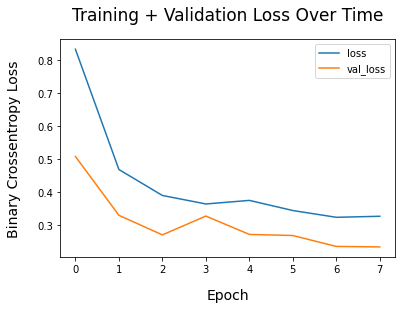

In [15]:

# Build train_history
# history_df1 = pd.DataFrame(train_history1.history)
# history_df2 = pd.DataFrame(train_history2.history)
# history_df = history_df1.append(history_df2, ignore_index=True)

history_df = pd.DataFrame(train_history1.history)

# Plot training and validation loss over each epoch
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title(label='Training + Validation Loss Over Time', fontsize=17, pad=19)
plt.xlabel('Epoch', labelpad=14, fontsize=14)
plt.ylabel('Binary Crossentropy Loss', labelpad=16, fontsize=14)
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# Save figure
plt.savefig('balanced_trainvalloss_16STEP_8EPOCH.png', dpi=300.0, transparent=True)

In [16]:

# Build train_history
history_df1 = pd.DataFrame(train_history1.history)
history_df2 = pd.DataFrame(train_history2.history)
history_df = history_df1.append(history_df2, ignore_index=True)

# Plot training and validation loss over each epoch
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.title(label='Training + Validation Loss Over Time', fontsize=17, pad=19)
plt.xlabel('Epoch', labelpad=14, fontsize=14)
plt.ylabel('Binary Crossentropy Loss', labelpad=16, fontsize=14)
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# Save figure
plt.savefig('balanced_trainvalloss_16STEP_8EPOCH_Full.png', dpi=300.0, transparent=True)

NameError: name 'train_history2' is not defined

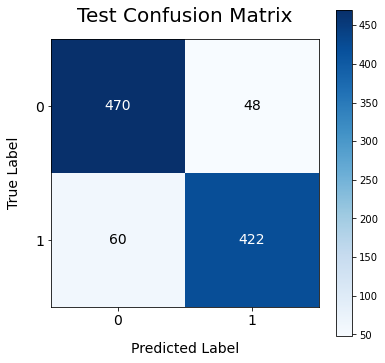

In [18]:
# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test.to_list(),
                                    y_pred_thresh.tolist(),
                                    figsize=(6,6),
                                    text_fontsize=14)
plt.title(label='Test Confusion Matrix', fontsize=20, pad=17)
plt.xlabel('Predicted Label', labelpad=14)
plt.ylabel('True Label', labelpad=14)

# Save the figure
plt.savefig('balanced_confusionmatrix.png', dpi=300.0, transparent=True)

In [5]:

def augment_sentence(sentence, aug, num_threads):
    """""""""
    Constructs a new sentence via text augmentation.
    
    Input:
        - sentence:     A string of text
        - aug:          An augmentation object defined by the nlpaug library
        - num_threads:  Integer controlling the number of threads to use if
                        augmenting text via CPU
    Output:
        - A string of text that been augmented
    """""""""
    return aug.augment(sentence[:512], num_thread=num_threads)
    


def augment_text(df, aug, num_threads, num_times, review_type):
    """""""""
    Takes a pandas DataFrame and augments its text data.
    
    Input:
        - df:            A pandas DataFrame containing the columns:
                                - 'comment_text' containing strings of text to augment.
                                - 'isToxic' binary target variable containing 0's and 1's.
        - aug:           Augmentation object defined by the nlpaug library.
        - num_threads:   Integer controlling number of threads to use if augmenting
                         text via CPU
        - num_times:     Integer representing the number of times to augment text.
        - review_type:   Type of review to augment (postive or negative)
    Output:
        - df:            Copy of the same pandas DataFrame with augmented data 
                         appended to it and with rows randomly shuffled.
    """""""""
    
    # Get rows of data to augment
    data =df[df['Result'] == review_type]
    totalRows=data.shape[0]
    """
    According to https://arxiv.org/pdf/1901.11196.pdf Average Accuracy increased to 88.6% using performing EDA on  
    50 % of its Total training dataset. 
    """
    to_augment = data.sample(n = ((int)(totalRows/2)))  #Augment 50% of data 
    to_augmentX = to_augment['Comment']
    to_augmentY = None
    if review_type== 1:
        to_augmentY = np.ones(len(to_augmentX.index) * num_times, dtype=np.int8);
    else:
        to_augmentY = np.zeros(len(to_augmentX.index) * num_times, dtype=np.int8);


    # Build up dictionary containing augmented data
    aug_dict = {'Comment': [], 'Result': to_augmentY}
    for i in tqdm(range(num_times)):
        print(i)
        augX = [augment_sentence(x, aug, num_threads) for x in to_augmentX]
        aug_dict['Comment'].extend(augX)
    
    # Build DataFrame containing augmented data
    aug_df = pd.DataFrame.from_dict(aug_dict)
    
    return df.append(aug_df, ignore_index=True).sample(frac=1, random_state=42)
    

    
# Define nlpaug augmentation object 
aug10p = nlpaw.ContextualWordEmbsAug(model_path='bert-base-uncased', aug_min=1, aug_p=0.1, action="substitute")

# Augment Negative class ([0] == 1)
df = augment_text(df, aug10p, num_threads=8, num_times=2,review_type=0)
# Augment Positive class ([0] == 1)
df_train_valid = augment_text(df, aug10p, num_threads=8, num_times=2,review_type=1)

  0%|          | 0/2 [00:00<?, ?it/s]

0


 50%|█████     | 1/2 [50:17<50:17, 3017.28s/it]

1


  0%|          | 0/2 [00:00<?, ?it/s]

0


 50%|█████     | 1/2 [46:25<46:25, 2785.71s/it]

1


100%|██████████| 2/2 [1:32:39<00:00, 2779.76s/it]


In [12]:
df_train_valid["Result"].value_counts()

1    4480
0    4480
Name: Result, dtype: int64

In [13]:
# Generate 80-20 train-validation splits
X_train, X_valid, y_train, y_valid = train_test_split(df_train_valid["Comment"],
                                                      df_train_valid["Result"],
                                                      train_size=0.8,
                                                      stratify=df_train_valid['Result'],
                                                      shuffle=True,
                                                      random_state=42)


In [14]:
# Train the model
train_history3 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = params['EPOCHS'],
    batch_size = params['BATCH_SIZE'],
    steps_per_epoch = params['NUM_STEPS'],
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=1
)

Epoch 1/8
16/16 [==============================] - 751s 49s/step - loss: 0.3707 - accuracy: 0.8408 - val_loss: 0.3121 - val_accuracy: 0.8677
Epoch 2/8
16/16 [==============================] - 786s 51s/step - loss: 0.3906 - accuracy: 0.8203 - val_loss: 0.3168 - val_accuracy: 0.8672
Epoch 3/8
16/16 [==============================] - 795s 52s/step - loss: 0.3556 - accuracy: 0.8613 - val_loss: 0.3285 - val_accuracy: 0.8577
Epoch 4/8
16/16 [==============================] - 781s 51s/step - loss: 0.3370 - accuracy: 0.8506 - val_loss: 0.3009 - val_accuracy: 0.8728
Epoch 5/8
16/16 [==============================] - 782s 51s/step - loss: 0.3559 - accuracy: 0.8457 - val_loss: 0.3028 - val_accuracy: 0.8694
Epoch 6/8
16/16 [==============================] - 794s 52s/step - loss: 0.3543 - accuracy: 0.8369 - val_loss: 0.3285 - val_accuracy: 0.8482
Epoch 7/8
16/16 [==============================] - 788s 51s/step - loss: 0.3562 - accuracy: 0.8389 - val_loss: 0.3482 - val_accuracy: 0.8309
Epoch 8/8
16/

In [ ]:
# Test Results with Data Augmentation
data = test[:1000]
X_test= data["Comment"]
y_test = data["Result"]
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())
y_pred = model.predict([X_test_ids, X_test_attention])
y_pred_thresh = np.where(y_pred >= params['POS_PROBA_THRESHOLD'], 1, 0)

# Get evaluation results
accuracy = accuracy_score(y_test, y_pred_thresh)
auc_roc = roc_auc_score(y_test, y_pred)

# Log the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred)
print('Accuracy:  ', accuracy)    # 0.892
print('ROC-AUC:   ', auc_roc) 